### Importing required packages

In [8]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from collections import Counter, OrderedDict
from torchtext.vocab import vocab
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os 
from pathlib import Path

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Some Hyperparameters

In [3]:
VOCAB_SIZE = 25000
THRESHOLD_FREQ = 5
BATCH_SIZE = 32

### Importing data

In [4]:
!pip install gdown

In [5]:
!gdown 1ZDFmDZDOi_hrfXrKYHjt9RorHBEcT1mq

Downloading...
From: https://drive.google.com/uc?id=1ZDFmDZDOi_hrfXrKYHjt9RorHBEcT1mq
To: /kaggle/working/imdb_data.csv
100%|███████████████████████████████████████| 66.0M/66.0M [00:00<00:00, 193MB/s]


In [9]:
df = pd.read_csv(Path(os.path.join(os.getcwd(),'imdb_data.csv')))
df.head()

,Review,Rating,Sentiment
0,Imagine The Big Chill with a cast of twenty-so...,2,0
1,I'd have to say that I've seen worse Sci Fi Ch...,3,0
2,Director Fabio Barreto got a strange Academy N...,1,0
3,Pretty bad PRC cheapie which I rarely bother t...,4,0
4,This is a very intriguing short movie by David...,8,1


In [10]:
X = df['Review'].values 
y = df['Sentiment'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

### Tokenizer

In [11]:
def tokenizer(text):
    # Replacing n't with not since it could be really important in sentiment analysis
    text = re.sub("n't", ' not ', text)
    # Removing URLs
    text = re.sub('(http).*\/', ' ', text)
    # Removing HTML tags
    text = re.sub('<[^>]*>', '', text)
    # Extracting emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|P|D|]|})', text)
    # Removing punctuations
    text = re.sub('[\W]+', ' ', text.lower())
    # Adding emoticons at end and converting :-) to :)
    text = text + ' ' + ' '.join(emoticons).replace('-', '')
    
    return text.split()

Vocabulary size = 85908


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


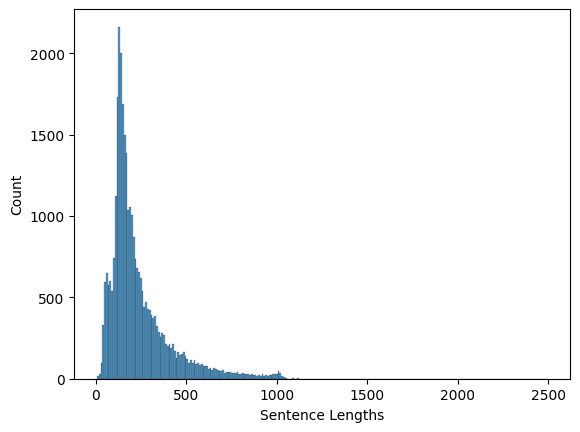

In [12]:
token_counter = Counter()
lengths = []
for review in X_train:
    tokens = tokenizer(review)
    lengths.append(len(tokens))
    token_counter.update(tokens)
print(f'Vocabulary size = {len(token_counter)}')
sns.histplot(lengths)
plt.xlabel('Sentence Lengths')
plt.show()

### Vocabulary class

In [13]:
class Vocabulary:    
    def __init__(self):
        self.vocabulary = None 
        
    def build_vocabulary(self, sentences):
        token_counter = Counter()
        for sentence in sentences:
            token_counter.update(tokenizer(sentence))
        sorted_by_freq_tuples = sorted(token_counter.items(), key=lambda x: x[1], reverse=True)[:VOCAB_SIZE]
        ordered_dict = OrderedDict(sorted_by_freq_tuples)
        specials = ['<PAD>', '<UNK>']
        self.vocabulary = vocab(ordered_dict, specials=specials, min_freq=THRESHOLD_FREQ)
        self.vocabulary.set_default_index(self.vocabulary['<UNK>'])
    
    def numericalize(self, sentence):
        tokenized_sentence = tokenizer(sentence)
        return [self.vocabulary[token] if token in self.vocabulary else self.vocabulary['<UNK>'] for token in tokenized_sentence] 
    
    def denumericalize(self, list):
        return [self.vocabulary.get_itos()[idx] if idx < len(self.vocabulary) else '<UNK>' for idx in list ]

### Custom Dataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, reviews_list, sentiment_list, vocabulary):
        super(CustomDataset, self).__init__()
        self.reviews = reviews_list 
        self.targets = sentiment_list 
        self.v1 = vocabulary
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        review = self.reviews[index]
        target = self.targets[index]
        
        numericalized_review = torch.tensor(self.v1.numericalize(review))
        
        return numericalized_review, torch.tensor(target).unsqueeze(0).float()

### Collate Function

In [15]:
class Collate:
    def __init__(self, pad_idx) :
        self.pad_idx = pad_idx 
    
    def __call__(self, batch) :
        reviews = [item[0] for item in batch]
        reviews = pad_sequence(reviews, batch_first=True, padding_value=self.pad_idx)
        targets = torch.cat([item[1].unsqueeze(0) for item in batch], dim=0)
        return reviews, targets

### DataLoader

In [16]:
def get_dataloader(reviews_list, sentiment_list, vocabulary, batch_size, shuffle=True):
    dataset = CustomDataset(reviews_list, sentiment_list, vocabulary)
    pad_idx = dataset.v1.vocabulary['<PAD>']
    dataloader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        collate_fn = Collate(pad_idx=pad_idx)
    )
    return dataloader

In [17]:
v1 = Vocabulary()
v1.build_vocabulary(X_train)
train_loader = get_dataloader(X_train, y_train, v1, BATCH_SIZE)
valid_loader = get_dataloader(X_valid, y_valid, v1, BATCH_SIZE)
test_loader = get_dataloader(X_test, y_test, v1, BATCH_SIZE)

### Checkpoint Functions

In [18]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [19]:
def load_checkpoint(model, optimizer, filename = 'checkpoint.pth.tar'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    max_accuracy = checkpoint['max_acc']
    best_model = checkpoint['best_model']
    return model, optimizer, max_accuracy, best_model

### Getting Accuracy

In [20]:
def get_accuracy(model, data_loader, loss_fn):
    total_correct = 0.0
    total_loss = 0.0
    with torch.no_grad():
        model.eval()
        for _, batch in enumerate(data_loader):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            y_preds = model(inputs)
            loss = loss_fn(y_preds, labels)
            total_loss += loss.item()*len(inputs)
            correct_counts = (torch.where(y_preds>0.5, 1, 0) == labels).float().sum().item()
            total_correct += correct_counts
    accuracy = total_correct/len(data_loader.dataset)*100
    avg_loss = total_loss/len(data_loader.dataset)  
    return accuracy, avg_loss

### Training

In [21]:
def training(model, model_name, optimizer, scheduler, loss_fn, train_data_loader, valid_data_loader, load_model=False, save_model=True, num_epochs = 10, patience=5):
    history = []
    max_accuracy = 0.0
    best_model = None
    if load_model:
        model, optimizer, max_accuracy, best_model = load_checkpoint(model, optimizer, checkpoint, model_name + model_name + '_checkpoint.pth.tar')
    count = 0
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for batch_idx, batch in enumerate(train_data_loader):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            y_preds = model(inputs)
            loss = loss_fn(y_preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0 :
                print(f'Epoch No. {epoch+1}/{num_epochs} | Batch No. {batch_idx}/{len(train_data_loader)} | Loss = {loss:.5f}')
        training_accuracy, training_loss = get_accuracy(model, train_data_loader, loss_fn)
        valid_accuracy, valid_loss = get_accuracy(model, valid_data_loader, loss_fn)
        print(f'Training Accuracy = {training_accuracy:.2f}% | Loss = {training_loss:.4f}')
        print(f'Valid Accuracy = {valid_accuracy:.2f}% | Loss = {valid_loss:.4f}')
        history.append([training_accuracy, training_loss, valid_accuracy, valid_loss])
        scheduler.step(valid_loss)
        if valid_accuracy > max_accuracy :
            count = 0
            max_accuracy = valid_accuracy
            checkpoint = {
                'model'      : model.state_dict(),
                'optimizer'  : optimizer.state_dict(),
                'best_model' : model.state_dict(),
                'max_acc'    : valid_accuracy
            }
            best_model = model.state_dict()
            if save_model:
                save_checkpoint(checkpoint, model_name + '_checkpoint.pth.tar')
        else :
            count += 1
            checkpoint = {
                'model'      : model.state_dict(),
                'optimizer'  : optimizer.state_dict(),
                'best_model' : best_model,
                'max_acc'    : max_accuracy
            }
            if save_model:
                save_checkpoint(checkpoint, model_name + '_checkpoint.pth.tar')
            if (count >= patience):
                print(f'Early stop at Epoch Number {epoch + 1}')
                break 
    return model, history    

### Post Training

In [22]:
def post_training(trained_model, loss_fn, test_loader, history, model_name):
    test_loss, test_acc = get_accuracy(trained_model, test_loader, loss_fn)
    history_np = np.array(history)
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    epochs_list = np.arange(1, len(history_np)+1)
    axes[0].plot(epochs_list, history_np[:, 0], label = "Training Accuracy", marker = '.')
    axes[0].plot(epochs_list, history_np[:, 2], label = "Validation Accuracy", marker = '.')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(epochs_list, history_np[:, 1], label = "Training Loss", marker = '.')
    axes[1].plot(epochs_list, history_np[:, 3], label = "Validation Loss", marker = '.')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    fig.suptitle(f'Training for {model_name}')
    plt.show()
    return test_loss, test_acc

### LSTM Model

In [23]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:,-1,:]
        out = self.fc(out)
        return out   

In [24]:
model = LSTM(vocab_size=len(v1.vocabulary), embed_size = 128, hidden_size = 128)
learning_rate = 0.002
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epochs = 10
patience = 5
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
model.to(device)
print(model)

LSTM(
  (embedding): Embedding(25002, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [25]:
trained_model , history_model = training(model, 'LSTM', optimizer, scheduler, loss_fn, train_loader, valid_loader, load_model=False, save_model=True, num_epochs = 100, patience=10)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch No. 1/100 | Batch No. 0/1000 | Loss = 0.69502
Epoch No. 1/100 | Batch No. 100/1000 | Loss = 0.68921
Epoch No. 1/100 | Batch No. 200/1000 | Loss = 0.70379
Epoch No. 1/100 | Batch No. 300/1000 | Loss = 0.69070
Epoch No. 1/100 | Batch No. 400/1000 | Loss = 0.69279
Epoch No. 1/100 | Batch No. 500/1000 | Loss = 0.69585
Epoch No. 1/100 | Batch No. 600/1000 | Loss = 0.69699
Epoch No. 1/100 | Batch No. 700/1000 | Loss = 0.68800
Epoch No. 1/100 | Batch No. 800/1000 | Loss = 0.68838
Epoch No. 1/100 | Batch No. 900/1000 | Loss = 0.68913


  1%|          | 1/100 [01:05<1:47:16, 65.01s/it]

Training Accuracy = 50.41% | Loss = 0.6909
Valid Accuracy = 50.04% | Loss = 0.6923
Epoch No. 2/100 | Batch No. 0/1000 | Loss = 0.68003
Epoch No. 2/100 | Batch No. 100/1000 | Loss = 0.68667
Epoch No. 2/100 | Batch No. 200/1000 | Loss = 0.67864
Epoch No. 2/100 | Batch No. 300/1000 | Loss = 0.69893
Epoch No. 2/100 | Batch No. 400/1000 | Loss = 0.67464
Epoch No. 2/100 | Batch No. 500/1000 | Loss = 0.67615
Epoch No. 2/100 | Batch No. 600/1000 | Loss = 0.69655
Epoch No. 2/100 | Batch No. 700/1000 | Loss = 0.68347
Epoch No. 2/100 | Batch No. 800/1000 | Loss = 0.66761
Epoch No. 2/100 | Batch No. 900/1000 | Loss = 0.68794


  2%|▏         | 2/100 [02:11<1:47:33, 65.85s/it]

Training Accuracy = 50.63% | Loss = 0.6879
Valid Accuracy = 50.05% | Loss = 0.6925
Epoch No. 3/100 | Batch No. 0/1000 | Loss = 0.68928
Epoch No. 3/100 | Batch No. 100/1000 | Loss = 0.69230
Epoch No. 3/100 | Batch No. 200/1000 | Loss = 0.69039
Epoch No. 3/100 | Batch No. 300/1000 | Loss = 0.70666
Epoch No. 3/100 | Batch No. 400/1000 | Loss = 0.72162
Epoch No. 3/100 | Batch No. 500/1000 | Loss = 0.69324
Epoch No. 3/100 | Batch No. 600/1000 | Loss = 0.67529
Epoch No. 3/100 | Batch No. 700/1000 | Loss = 0.67080
Epoch No. 3/100 | Batch No. 800/1000 | Loss = 0.73454
Epoch No. 3/100 | Batch No. 900/1000 | Loss = 0.67521


  3%|▎         | 3/100 [03:16<1:46:13, 65.71s/it]

Training Accuracy = 50.92% | Loss = 0.6845
Valid Accuracy = 50.18% | Loss = 0.6923
Epoch No. 4/100 | Batch No. 0/1000 | Loss = 0.67510
Epoch No. 4/100 | Batch No. 100/1000 | Loss = 0.76229
Epoch No. 4/100 | Batch No. 200/1000 | Loss = 0.67267
Epoch No. 4/100 | Batch No. 300/1000 | Loss = 0.68631
Epoch No. 4/100 | Batch No. 400/1000 | Loss = 0.67629
Epoch No. 4/100 | Batch No. 500/1000 | Loss = 0.69650
Epoch No. 4/100 | Batch No. 600/1000 | Loss = 0.67401
Epoch No. 4/100 | Batch No. 700/1000 | Loss = 0.69383
Epoch No. 4/100 | Batch No. 800/1000 | Loss = 0.67017
Epoch No. 4/100 | Batch No. 900/1000 | Loss = 0.67559


  4%|▍         | 4/100 [04:21<1:44:14, 65.15s/it]

Training Accuracy = 51.30% | Loss = 0.6828
Valid Accuracy = 50.68% | Loss = 0.6929
Epoch No. 5/100 | Batch No. 0/1000 | Loss = 0.66941
Epoch No. 5/100 | Batch No. 100/1000 | Loss = 0.67327
Epoch No. 5/100 | Batch No. 200/1000 | Loss = 0.70218
Epoch No. 5/100 | Batch No. 300/1000 | Loss = 0.67980
Epoch No. 5/100 | Batch No. 400/1000 | Loss = 0.69013
Epoch No. 5/100 | Batch No. 500/1000 | Loss = 0.55991
Epoch No. 5/100 | Batch No. 600/1000 | Loss = 0.65212
Epoch No. 5/100 | Batch No. 700/1000 | Loss = 0.49912
Epoch No. 5/100 | Batch No. 800/1000 | Loss = 0.44718
Epoch No. 5/100 | Batch No. 900/1000 | Loss = 0.45817


  5%|▌         | 5/100 [05:25<1:42:39, 64.84s/it]

Training Accuracy = 79.11% | Loss = 0.4729
Valid Accuracy = 74.60% | Loss = 0.5398
Epoch No. 6/100 | Batch No. 0/1000 | Loss = 0.56383
Epoch No. 6/100 | Batch No. 100/1000 | Loss = 0.50648
Epoch No. 6/100 | Batch No. 200/1000 | Loss = 0.47137
Epoch No. 6/100 | Batch No. 300/1000 | Loss = 0.57066
Epoch No. 6/100 | Batch No. 400/1000 | Loss = 0.38938
Epoch No. 6/100 | Batch No. 500/1000 | Loss = 0.51848
Epoch No. 6/100 | Batch No. 600/1000 | Loss = 0.42878
Epoch No. 6/100 | Batch No. 700/1000 | Loss = 0.47712
Epoch No. 6/100 | Batch No. 800/1000 | Loss = 0.31840
Epoch No. 6/100 | Batch No. 900/1000 | Loss = 0.40179


  6%|▌         | 6/100 [06:29<1:41:15, 64.63s/it]

Training Accuracy = 93.20% | Loss = 0.2014
Valid Accuracy = 86.64% | Loss = 0.3183
Epoch No. 7/100 | Batch No. 0/1000 | Loss = 0.24860
Epoch No. 7/100 | Batch No. 100/1000 | Loss = 0.10316
Epoch No. 7/100 | Batch No. 200/1000 | Loss = 0.34070
Epoch No. 7/100 | Batch No. 300/1000 | Loss = 0.14564
Epoch No. 7/100 | Batch No. 400/1000 | Loss = 0.17964
Epoch No. 7/100 | Batch No. 500/1000 | Loss = 0.22463
Epoch No. 7/100 | Batch No. 600/1000 | Loss = 0.20229
Epoch No. 7/100 | Batch No. 700/1000 | Loss = 0.28559
Epoch No. 7/100 | Batch No. 800/1000 | Loss = 0.40247
Epoch No. 7/100 | Batch No. 900/1000 | Loss = 0.11506


  7%|▋         | 7/100 [07:34<1:40:00, 64.52s/it]

Training Accuracy = 96.45% | Loss = 0.1245
Valid Accuracy = 86.92% | Loss = 0.3333
Epoch No. 8/100 | Batch No. 0/1000 | Loss = 0.22205
Epoch No. 8/100 | Batch No. 100/1000 | Loss = 0.29479
Epoch No. 8/100 | Batch No. 200/1000 | Loss = 0.03460
Epoch No. 8/100 | Batch No. 300/1000 | Loss = 0.13137
Epoch No. 8/100 | Batch No. 400/1000 | Loss = 0.18379
Epoch No. 8/100 | Batch No. 500/1000 | Loss = 0.04092
Epoch No. 8/100 | Batch No. 600/1000 | Loss = 0.08001
Epoch No. 8/100 | Batch No. 700/1000 | Loss = 0.04293
Epoch No. 8/100 | Batch No. 800/1000 | Loss = 0.01137
Epoch No. 8/100 | Batch No. 900/1000 | Loss = 0.12646


  8%|▊         | 8/100 [08:38<1:38:46, 64.41s/it]

Training Accuracy = 98.27% | Loss = 0.0686
Valid Accuracy = 88.10% | Loss = 0.3483
Epoch No. 9/100 | Batch No. 0/1000 | Loss = 0.05599
Epoch No. 9/100 | Batch No. 100/1000 | Loss = 0.01441
Epoch No. 9/100 | Batch No. 200/1000 | Loss = 0.19843
Epoch No. 9/100 | Batch No. 300/1000 | Loss = 0.01281
Epoch No. 9/100 | Batch No. 400/1000 | Loss = 0.08422
Epoch No. 9/100 | Batch No. 500/1000 | Loss = 0.06444
Epoch No. 9/100 | Batch No. 600/1000 | Loss = 0.08292
Epoch No. 9/100 | Batch No. 700/1000 | Loss = 0.02282
Epoch No. 9/100 | Batch No. 800/1000 | Loss = 0.19489
Epoch No. 9/100 | Batch No. 900/1000 | Loss = 0.16592


  9%|▉         | 9/100 [09:42<1:37:37, 64.36s/it]

Training Accuracy = 98.88% | Loss = 0.0478
Valid Accuracy = 88.10% | Loss = 0.4012
Epoch No. 10/100 | Batch No. 0/1000 | Loss = 0.17650
Epoch No. 10/100 | Batch No. 100/1000 | Loss = 0.12105
Epoch No. 10/100 | Batch No. 200/1000 | Loss = 0.00549
Epoch No. 10/100 | Batch No. 300/1000 | Loss = 0.00498
Epoch No. 10/100 | Batch No. 400/1000 | Loss = 0.00874
Epoch No. 10/100 | Batch No. 500/1000 | Loss = 0.00628
Epoch No. 10/100 | Batch No. 600/1000 | Loss = 0.00665
Epoch No. 10/100 | Batch No. 700/1000 | Loss = 0.30098
Epoch No. 10/100 | Batch No. 800/1000 | Loss = 0.10144
Epoch No. 10/100 | Batch No. 900/1000 | Loss = 0.01220


 10%|█         | 10/100 [10:46<1:36:31, 64.35s/it]

Training Accuracy = 99.22% | Loss = 0.0370
Valid Accuracy = 87.52% | Loss = 0.4400
Epoch No. 11/100 | Batch No. 0/1000 | Loss = 0.00800
Epoch No. 11/100 | Batch No. 100/1000 | Loss = 0.18529
Epoch No. 11/100 | Batch No. 200/1000 | Loss = 0.03731
Epoch No. 11/100 | Batch No. 300/1000 | Loss = 0.00470
Epoch No. 11/100 | Batch No. 400/1000 | Loss = 0.00808
Epoch No. 11/100 | Batch No. 500/1000 | Loss = 0.16649
Epoch No. 11/100 | Batch No. 600/1000 | Loss = 0.00386
Epoch No. 11/100 | Batch No. 700/1000 | Loss = 0.03430
Epoch No. 11/100 | Batch No. 800/1000 | Loss = 0.24452
Epoch No. 11/100 | Batch No. 900/1000 | Loss = 0.00688


 11%|█         | 11/100 [11:51<1:35:30, 64.39s/it]

Training Accuracy = 99.09% | Loss = 0.0388
Valid Accuracy = 87.86% | Loss = 0.3965
Epoch No. 12/100 | Batch No. 0/1000 | Loss = 0.13903
Epoch No. 12/100 | Batch No. 100/1000 | Loss = 0.00492
Epoch No. 12/100 | Batch No. 200/1000 | Loss = 0.00488
Epoch No. 12/100 | Batch No. 300/1000 | Loss = 0.17280
Epoch No. 12/100 | Batch No. 400/1000 | Loss = 0.01032
Epoch No. 12/100 | Batch No. 500/1000 | Loss = 0.20805
Epoch No. 12/100 | Batch No. 600/1000 | Loss = 0.02399
Epoch No. 12/100 | Batch No. 700/1000 | Loss = 0.04696
Epoch No. 12/100 | Batch No. 800/1000 | Loss = 0.00749
Epoch No. 12/100 | Batch No. 900/1000 | Loss = 0.14624


 12%|█▏        | 12/100 [12:55<1:34:30, 64.44s/it]

Training Accuracy = 99.29% | Loss = 0.0311
Valid Accuracy = 88.00% | Loss = 0.4569
Epoch No. 13/100 | Batch No. 0/1000 | Loss = 0.00665
Epoch No. 13/100 | Batch No. 100/1000 | Loss = 0.00518
Epoch No. 13/100 | Batch No. 200/1000 | Loss = 0.00267
Epoch No. 13/100 | Batch No. 300/1000 | Loss = 0.02639
Epoch No. 13/100 | Batch No. 400/1000 | Loss = 0.12479
Epoch No. 13/100 | Batch No. 500/1000 | Loss = 0.01747
Epoch No. 13/100 | Batch No. 600/1000 | Loss = 0.10280
Epoch No. 13/100 | Batch No. 700/1000 | Loss = 0.00369
Epoch No. 13/100 | Batch No. 800/1000 | Loss = 0.00659
Epoch No. 13/100 | Batch No. 900/1000 | Loss = 0.12213


 13%|█▎        | 13/100 [14:00<1:33:26, 64.44s/it]

Training Accuracy = 99.48% | Loss = 0.0247
Valid Accuracy = 88.14% | Loss = 0.4437
Epoch No. 14/100 | Batch No. 0/1000 | Loss = 0.17577
Epoch No. 14/100 | Batch No. 100/1000 | Loss = 0.00252
Epoch No. 14/100 | Batch No. 200/1000 | Loss = 0.00866
Epoch No. 14/100 | Batch No. 300/1000 | Loss = 0.00294
Epoch No. 14/100 | Batch No. 400/1000 | Loss = 0.17546
Epoch No. 14/100 | Batch No. 500/1000 | Loss = 0.01791
Epoch No. 14/100 | Batch No. 600/1000 | Loss = 0.00198
Epoch No. 14/100 | Batch No. 700/1000 | Loss = 0.00094
Epoch No. 14/100 | Batch No. 800/1000 | Loss = 0.13550
Epoch No. 14/100 | Batch No. 900/1000 | Loss = 0.00357


 14%|█▍        | 14/100 [15:04<1:32:12, 64.34s/it]

Training Accuracy = 98.90% | Loss = 0.0366
Valid Accuracy = 86.88% | Loss = 0.5254
Epoch No. 15/100 | Batch No. 0/1000 | Loss = 0.02291
Epoch No. 15/100 | Batch No. 100/1000 | Loss = 0.00337
Epoch No. 15/100 | Batch No. 200/1000 | Loss = 0.00327
Epoch No. 15/100 | Batch No. 300/1000 | Loss = 0.17464
Epoch No. 15/100 | Batch No. 400/1000 | Loss = 0.29528
Epoch No. 15/100 | Batch No. 500/1000 | Loss = 0.12642
Epoch No. 15/100 | Batch No. 600/1000 | Loss = 0.00453
Epoch No. 15/100 | Batch No. 700/1000 | Loss = 0.00500
Epoch No. 15/100 | Batch No. 800/1000 | Loss = 0.00315
Epoch No. 15/100 | Batch No. 900/1000 | Loss = 0.00346


 15%|█▌        | 15/100 [16:08<1:31:07, 64.32s/it]

Training Accuracy = 99.28% | Loss = 0.0272
Valid Accuracy = 87.45% | Loss = 0.4898
Epoch No. 16/100 | Batch No. 0/1000 | Loss = 0.00335
Epoch No. 16/100 | Batch No. 100/1000 | Loss = 0.00355
Epoch No. 16/100 | Batch No. 200/1000 | Loss = 0.00223
Epoch No. 16/100 | Batch No. 300/1000 | Loss = 0.00097
Epoch No. 16/100 | Batch No. 400/1000 | Loss = 0.00216
Epoch No. 16/100 | Batch No. 500/1000 | Loss = 0.02957
Epoch No. 16/100 | Batch No. 600/1000 | Loss = 0.00227
Epoch No. 16/100 | Batch No. 700/1000 | Loss = 0.02025
Epoch No. 16/100 | Batch No. 800/1000 | Loss = 0.00507
Epoch No. 16/100 | Batch No. 900/1000 | Loss = 0.04766


 16%|█▌        | 16/100 [17:12<1:29:57, 64.26s/it]

Training Accuracy = 99.61% | Loss = 0.0179
Valid Accuracy = 88.24% | Loss = 0.5288
Epoch No. 17/100 | Batch No. 0/1000 | Loss = 0.11152
Epoch No. 17/100 | Batch No. 100/1000 | Loss = 0.00391
Epoch No. 17/100 | Batch No. 200/1000 | Loss = 0.00297
Epoch No. 17/100 | Batch No. 300/1000 | Loss = 0.00642
Epoch No. 17/100 | Batch No. 400/1000 | Loss = 0.02000
Epoch No. 17/100 | Batch No. 500/1000 | Loss = 0.00269
Epoch No. 17/100 | Batch No. 600/1000 | Loss = 0.00256
Epoch No. 17/100 | Batch No. 700/1000 | Loss = 0.00518
Epoch No. 17/100 | Batch No. 800/1000 | Loss = 0.20683
Epoch No. 17/100 | Batch No. 900/1000 | Loss = 0.06630


 17%|█▋        | 17/100 [18:17<1:28:55, 64.29s/it]

Training Accuracy = 99.25% | Loss = 0.0270
Valid Accuracy = 87.17% | Loss = 0.5985
Epoch No. 18/100 | Batch No. 0/1000 | Loss = 0.07418
Epoch No. 18/100 | Batch No. 100/1000 | Loss = 0.00513
Epoch No. 18/100 | Batch No. 200/1000 | Loss = 0.00249
Epoch No. 18/100 | Batch No. 300/1000 | Loss = 0.00392
Epoch No. 18/100 | Batch No. 400/1000 | Loss = 0.00232
Epoch No. 18/100 | Batch No. 500/1000 | Loss = 0.00117
Epoch No. 18/100 | Batch No. 600/1000 | Loss = 0.00306
Epoch No. 18/100 | Batch No. 700/1000 | Loss = 0.00139
Epoch No. 18/100 | Batch No. 800/1000 | Loss = 0.00160
Epoch No. 18/100 | Batch No. 900/1000 | Loss = 0.00080


 18%|█▊        | 18/100 [19:20<1:27:39, 64.14s/it]

Training Accuracy = 99.86% | Loss = 0.0099
Valid Accuracy = 87.94% | Loss = 0.5745
Epoch No. 19/100 | Batch No. 0/1000 | Loss = 0.00111
Epoch No. 19/100 | Batch No. 100/1000 | Loss = 0.00112
Epoch No. 19/100 | Batch No. 200/1000 | Loss = 0.00165
Epoch No. 19/100 | Batch No. 300/1000 | Loss = 0.00100
Epoch No. 19/100 | Batch No. 400/1000 | Loss = 0.00209
Epoch No. 19/100 | Batch No. 500/1000 | Loss = 0.00072
Epoch No. 19/100 | Batch No. 600/1000 | Loss = 0.00334
Epoch No. 19/100 | Batch No. 700/1000 | Loss = 0.00099
Epoch No. 19/100 | Batch No. 800/1000 | Loss = 0.00264
Epoch No. 19/100 | Batch No. 900/1000 | Loss = 0.00130


 19%|█▉        | 19/100 [20:24<1:26:28, 64.05s/it]

Training Accuracy = 99.88% | Loss = 0.0089
Valid Accuracy = 88.11% | Loss = 0.6027
Epoch No. 20/100 | Batch No. 0/1000 | Loss = 0.00117
Epoch No. 20/100 | Batch No. 100/1000 | Loss = 0.00134
Epoch No. 20/100 | Batch No. 200/1000 | Loss = 0.00071
Epoch No. 20/100 | Batch No. 300/1000 | Loss = 0.00124
Epoch No. 20/100 | Batch No. 400/1000 | Loss = 0.00094
Epoch No. 20/100 | Batch No. 500/1000 | Loss = 0.00110
Epoch No. 20/100 | Batch No. 600/1000 | Loss = 0.00189
Epoch No. 20/100 | Batch No. 700/1000 | Loss = 0.00177
Epoch No. 20/100 | Batch No. 800/1000 | Loss = 0.00087
Epoch No. 20/100 | Batch No. 900/1000 | Loss = 0.00207


 20%|██        | 20/100 [21:28<1:25:19, 64.00s/it]

Training Accuracy = 99.88% | Loss = 0.0086
Valid Accuracy = 88.16% | Loss = 0.6194
Epoch No. 21/100 | Batch No. 0/1000 | Loss = 0.00132
Epoch No. 21/100 | Batch No. 100/1000 | Loss = 0.00166
Epoch No. 21/100 | Batch No. 200/1000 | Loss = 0.00121
Epoch No. 21/100 | Batch No. 300/1000 | Loss = 0.00117
Epoch No. 21/100 | Batch No. 400/1000 | Loss = 0.00090
Epoch No. 21/100 | Batch No. 500/1000 | Loss = 0.00086
Epoch No. 21/100 | Batch No. 600/1000 | Loss = 0.00091
Epoch No. 21/100 | Batch No. 700/1000 | Loss = 0.00115
Epoch No. 21/100 | Batch No. 800/1000 | Loss = 0.00093
Epoch No. 21/100 | Batch No. 900/1000 | Loss = 0.00127


 21%|██        | 21/100 [22:32<1:24:09, 63.91s/it]

Training Accuracy = 99.89% | Loss = 0.0081
Valid Accuracy = 88.19% | Loss = 0.6074
Epoch No. 22/100 | Batch No. 0/1000 | Loss = 0.00192
Epoch No. 22/100 | Batch No. 100/1000 | Loss = 0.00128
Epoch No. 22/100 | Batch No. 200/1000 | Loss = 0.00172
Epoch No. 22/100 | Batch No. 300/1000 | Loss = 0.00078
Epoch No. 22/100 | Batch No. 400/1000 | Loss = 0.00083
Epoch No. 22/100 | Batch No. 500/1000 | Loss = 0.00098
Epoch No. 22/100 | Batch No. 600/1000 | Loss = 0.00169
Epoch No. 22/100 | Batch No. 700/1000 | Loss = 0.00174
Epoch No. 22/100 | Batch No. 800/1000 | Loss = 0.00259
Epoch No. 22/100 | Batch No. 900/1000 | Loss = 0.00110


 22%|██▏       | 22/100 [23:36<1:23:02, 63.88s/it]

Training Accuracy = 99.89% | Loss = 0.0077
Valid Accuracy = 88.42% | Loss = 0.6211
Epoch No. 23/100 | Batch No. 0/1000 | Loss = 0.00115
Epoch No. 23/100 | Batch No. 100/1000 | Loss = 0.00058
Epoch No. 23/100 | Batch No. 200/1000 | Loss = 0.00071
Epoch No. 23/100 | Batch No. 300/1000 | Loss = 0.00158
Epoch No. 23/100 | Batch No. 400/1000 | Loss = 0.00215
Epoch No. 23/100 | Batch No. 500/1000 | Loss = 0.00233
Epoch No. 23/100 | Batch No. 600/1000 | Loss = 0.00104
Epoch No. 23/100 | Batch No. 700/1000 | Loss = 0.00078
Epoch No. 23/100 | Batch No. 800/1000 | Loss = 0.00059
Epoch No. 23/100 | Batch No. 900/1000 | Loss = 0.00131


 23%|██▎       | 23/100 [24:39<1:21:55, 63.84s/it]

Training Accuracy = 99.89% | Loss = 0.0075
Valid Accuracy = 88.39% | Loss = 0.6541
Epoch No. 24/100 | Batch No. 0/1000 | Loss = 0.00166
Epoch No. 24/100 | Batch No. 100/1000 | Loss = 0.00171
Epoch No. 24/100 | Batch No. 200/1000 | Loss = 0.00074
Epoch No. 24/100 | Batch No. 300/1000 | Loss = 0.00105
Epoch No. 24/100 | Batch No. 400/1000 | Loss = 0.00119
Epoch No. 24/100 | Batch No. 500/1000 | Loss = 0.00135
Epoch No. 24/100 | Batch No. 600/1000 | Loss = 0.00172
Epoch No. 24/100 | Batch No. 700/1000 | Loss = 0.17252
Epoch No. 24/100 | Batch No. 800/1000 | Loss = 0.00150
Epoch No. 24/100 | Batch No. 900/1000 | Loss = 0.21977


 24%|██▍       | 24/100 [25:43<1:20:51, 63.83s/it]

Training Accuracy = 99.90% | Loss = 0.0069
Valid Accuracy = 88.35% | Loss = 0.6412
Epoch No. 25/100 | Batch No. 0/1000 | Loss = 0.00075
Epoch No. 25/100 | Batch No. 100/1000 | Loss = 0.00096
Epoch No. 25/100 | Batch No. 200/1000 | Loss = 0.00123
Epoch No. 25/100 | Batch No. 300/1000 | Loss = 0.00082
Epoch No. 25/100 | Batch No. 400/1000 | Loss = 0.00090
Epoch No. 25/100 | Batch No. 500/1000 | Loss = 0.00098
Epoch No. 25/100 | Batch No. 600/1000 | Loss = 0.00092
Epoch No. 25/100 | Batch No. 700/1000 | Loss = 0.00106
Epoch No. 25/100 | Batch No. 800/1000 | Loss = 0.00114
Epoch No. 25/100 | Batch No. 900/1000 | Loss = 0.20439


 25%|██▌       | 25/100 [26:47<1:19:51, 63.89s/it]

Training Accuracy = 99.90% | Loss = 0.0066
Valid Accuracy = 88.46% | Loss = 0.6492
Epoch No. 26/100 | Batch No. 0/1000 | Loss = 0.00074
Epoch No. 26/100 | Batch No. 100/1000 | Loss = 0.00101
Epoch No. 26/100 | Batch No. 200/1000 | Loss = 0.00116
Epoch No. 26/100 | Batch No. 300/1000 | Loss = 0.00089
Epoch No. 26/100 | Batch No. 400/1000 | Loss = 0.00094
Epoch No. 26/100 | Batch No. 500/1000 | Loss = 0.00133
Epoch No. 26/100 | Batch No. 600/1000 | Loss = 0.00159
Epoch No. 26/100 | Batch No. 700/1000 | Loss = 0.00103
Epoch No. 26/100 | Batch No. 800/1000 | Loss = 0.00063
Epoch No. 26/100 | Batch No. 900/1000 | Loss = 0.00146


 26%|██▌       | 26/100 [27:52<1:19:06, 64.15s/it]

Training Accuracy = 99.91% | Loss = 0.0061
Valid Accuracy = 88.44% | Loss = 0.6777
Epoch No. 27/100 | Batch No. 0/1000 | Loss = 0.00071
Epoch No. 27/100 | Batch No. 100/1000 | Loss = 0.00111
Epoch No. 27/100 | Batch No. 200/1000 | Loss = 0.00062
Epoch No. 27/100 | Batch No. 300/1000 | Loss = 0.00112
Epoch No. 27/100 | Batch No. 400/1000 | Loss = 0.00296
Epoch No. 27/100 | Batch No. 500/1000 | Loss = 0.00189
Epoch No. 27/100 | Batch No. 600/1000 | Loss = 0.00040
Epoch No. 27/100 | Batch No. 700/1000 | Loss = 0.00042
Epoch No. 27/100 | Batch No. 800/1000 | Loss = 0.00146
Epoch No. 27/100 | Batch No. 900/1000 | Loss = 0.00069


 27%|██▋       | 27/100 [28:57<1:18:18, 64.37s/it]

Training Accuracy = 99.91% | Loss = 0.0057
Valid Accuracy = 88.50% | Loss = 0.6993
Epoch No. 28/100 | Batch No. 0/1000 | Loss = 0.00035
Epoch No. 28/100 | Batch No. 100/1000 | Loss = 0.00071
Epoch No. 28/100 | Batch No. 200/1000 | Loss = 0.00057
Epoch No. 28/100 | Batch No. 300/1000 | Loss = 0.00166
Epoch No. 28/100 | Batch No. 400/1000 | Loss = 0.00120
Epoch No. 28/100 | Batch No. 500/1000 | Loss = 0.00039
Epoch No. 28/100 | Batch No. 600/1000 | Loss = 0.00027
Epoch No. 28/100 | Batch No. 700/1000 | Loss = 0.00040
Epoch No. 28/100 | Batch No. 800/1000 | Loss = 0.00080
Epoch No. 28/100 | Batch No. 900/1000 | Loss = 0.00094


 28%|██▊       | 28/100 [30:01<1:17:11, 64.33s/it]

Training Accuracy = 99.91% | Loss = 0.0053
Valid Accuracy = 88.60% | Loss = 0.7118
Epoch No. 29/100 | Batch No. 0/1000 | Loss = 0.00054
Epoch No. 29/100 | Batch No. 100/1000 | Loss = 0.00110
Epoch No. 29/100 | Batch No. 200/1000 | Loss = 0.00094
Epoch No. 29/100 | Batch No. 300/1000 | Loss = 0.00126
Epoch No. 29/100 | Batch No. 400/1000 | Loss = 0.00063
Epoch No. 29/100 | Batch No. 500/1000 | Loss = 0.00084
Epoch No. 29/100 | Batch No. 600/1000 | Loss = 0.00035
Epoch No. 29/100 | Batch No. 700/1000 | Loss = 0.00066
Epoch No. 29/100 | Batch No. 800/1000 | Loss = 0.00036
Epoch No. 29/100 | Batch No. 900/1000 | Loss = 0.00061


 29%|██▉       | 29/100 [31:05<1:15:53, 64.14s/it]

Training Accuracy = 99.90% | Loss = 0.0055
Valid Accuracy = 88.60% | Loss = 0.7007
Epoch No. 30/100 | Batch No. 0/1000 | Loss = 0.00042
Epoch No. 30/100 | Batch No. 100/1000 | Loss = 0.00050
Epoch No. 30/100 | Batch No. 200/1000 | Loss = 0.00042
Epoch No. 30/100 | Batch No. 300/1000 | Loss = 0.00047
Epoch No. 30/100 | Batch No. 400/1000 | Loss = 0.00095
Epoch No. 30/100 | Batch No. 500/1000 | Loss = 0.00055
Epoch No. 30/100 | Batch No. 600/1000 | Loss = 0.00057
Epoch No. 30/100 | Batch No. 700/1000 | Loss = 0.00050
Epoch No. 30/100 | Batch No. 800/1000 | Loss = 0.00256
Epoch No. 30/100 | Batch No. 900/1000 | Loss = 0.00146


 30%|███       | 30/100 [32:08<1:14:35, 63.94s/it]

Training Accuracy = 99.91% | Loss = 0.0052
Valid Accuracy = 88.59% | Loss = 0.7227
Epoch No. 31/100 | Batch No. 0/1000 | Loss = 0.00041
Epoch No. 31/100 | Batch No. 100/1000 | Loss = 0.00040
Epoch No. 31/100 | Batch No. 200/1000 | Loss = 0.00036
Epoch No. 31/100 | Batch No. 300/1000 | Loss = 0.00047
Epoch No. 31/100 | Batch No. 400/1000 | Loss = 0.00056
Epoch No. 31/100 | Batch No. 500/1000 | Loss = 0.00070
Epoch No. 31/100 | Batch No. 600/1000 | Loss = 0.00079
Epoch No. 31/100 | Batch No. 700/1000 | Loss = 0.00299
Epoch No. 31/100 | Batch No. 800/1000 | Loss = 0.00079
Epoch No. 31/100 | Batch No. 900/1000 | Loss = 0.00091


 31%|███       | 31/100 [33:12<1:13:30, 63.92s/it]

Training Accuracy = 99.91% | Loss = 0.0052
Valid Accuracy = 88.64% | Loss = 0.7322
Epoch No. 32/100 | Batch No. 0/1000 | Loss = 0.00102
Epoch No. 32/100 | Batch No. 100/1000 | Loss = 0.00438
Epoch No. 32/100 | Batch No. 200/1000 | Loss = 0.00145
Epoch No. 32/100 | Batch No. 300/1000 | Loss = 0.00107
Epoch No. 32/100 | Batch No. 400/1000 | Loss = 0.17879
Epoch No. 32/100 | Batch No. 500/1000 | Loss = 0.00062
Epoch No. 32/100 | Batch No. 600/1000 | Loss = 0.00100
Epoch No. 32/100 | Batch No. 700/1000 | Loss = 0.00048
Epoch No. 32/100 | Batch No. 800/1000 | Loss = 0.00045
Epoch No. 32/100 | Batch No. 900/1000 | Loss = 0.00064


 32%|███▏      | 32/100 [34:16<1:12:19, 63.81s/it]

Training Accuracy = 99.91% | Loss = 0.0050
Valid Accuracy = 88.58% | Loss = 0.7213
Epoch No. 33/100 | Batch No. 0/1000 | Loss = 0.00055
Epoch No. 33/100 | Batch No. 100/1000 | Loss = 0.00060
Epoch No. 33/100 | Batch No. 200/1000 | Loss = 0.00030
Epoch No. 33/100 | Batch No. 300/1000 | Loss = 0.00102
Epoch No. 33/100 | Batch No. 400/1000 | Loss = 0.00053
Epoch No. 33/100 | Batch No. 500/1000 | Loss = 0.00051
Epoch No. 33/100 | Batch No. 600/1000 | Loss = 0.00034
Epoch No. 33/100 | Batch No. 700/1000 | Loss = 0.00045
Epoch No. 33/100 | Batch No. 800/1000 | Loss = 0.00048
Epoch No. 33/100 | Batch No. 900/1000 | Loss = 0.00078


 33%|███▎      | 33/100 [35:19<1:11:13, 63.79s/it]

Training Accuracy = 99.91% | Loss = 0.0050
Valid Accuracy = 88.56% | Loss = 0.7433
Epoch No. 34/100 | Batch No. 0/1000 | Loss = 0.00034
Epoch No. 34/100 | Batch No. 100/1000 | Loss = 0.00041
Epoch No. 34/100 | Batch No. 200/1000 | Loss = 0.16145
Epoch No. 34/100 | Batch No. 300/1000 | Loss = 0.00090
Epoch No. 34/100 | Batch No. 400/1000 | Loss = 0.00098
Epoch No. 34/100 | Batch No. 500/1000 | Loss = 0.00210
Epoch No. 34/100 | Batch No. 600/1000 | Loss = 0.00207
Epoch No. 34/100 | Batch No. 700/1000 | Loss = 0.00048
Epoch No. 34/100 | Batch No. 800/1000 | Loss = 0.00042
Epoch No. 34/100 | Batch No. 900/1000 | Loss = 0.00063


 34%|███▍      | 34/100 [36:23<1:10:13, 63.84s/it]

Training Accuracy = 99.91% | Loss = 0.0048
Valid Accuracy = 88.51% | Loss = 0.7497
Epoch No. 35/100 | Batch No. 0/1000 | Loss = 0.00048
Epoch No. 35/100 | Batch No. 100/1000 | Loss = 0.00034
Epoch No. 35/100 | Batch No. 200/1000 | Loss = 0.00049
Epoch No. 35/100 | Batch No. 300/1000 | Loss = 0.00068
Epoch No. 35/100 | Batch No. 400/1000 | Loss = 0.00046
Epoch No. 35/100 | Batch No. 500/1000 | Loss = 0.00047
Epoch No. 35/100 | Batch No. 600/1000 | Loss = 0.00024
Epoch No. 35/100 | Batch No. 700/1000 | Loss = 0.00069
Epoch No. 35/100 | Batch No. 800/1000 | Loss = 0.00056
Epoch No. 35/100 | Batch No. 900/1000 | Loss = 0.00346


 35%|███▌      | 35/100 [37:28<1:09:29, 64.15s/it]

Training Accuracy = 99.91% | Loss = 0.0046
Valid Accuracy = 88.55% | Loss = 0.7385
Epoch No. 36/100 | Batch No. 0/1000 | Loss = 0.00053
Epoch No. 36/100 | Batch No. 100/1000 | Loss = 0.13208
Epoch No. 36/100 | Batch No. 200/1000 | Loss = 0.00093
Epoch No. 36/100 | Batch No. 300/1000 | Loss = 0.00064
Epoch No. 36/100 | Batch No. 400/1000 | Loss = 0.00055
Epoch No. 36/100 | Batch No. 500/1000 | Loss = 0.00407
Epoch No. 36/100 | Batch No. 600/1000 | Loss = 0.00039
Epoch No. 36/100 | Batch No. 700/1000 | Loss = 0.00132
Epoch No. 36/100 | Batch No. 800/1000 | Loss = 0.00078
Epoch No. 36/100 | Batch No. 900/1000 | Loss = 0.00110


 36%|███▌      | 36/100 [38:33<1:08:26, 64.17s/it]

Training Accuracy = 99.91% | Loss = 0.0045
Valid Accuracy = 88.55% | Loss = 0.7560
Epoch No. 37/100 | Batch No. 0/1000 | Loss = 0.00032
Epoch No. 37/100 | Batch No. 100/1000 | Loss = 0.00135
Epoch No. 37/100 | Batch No. 200/1000 | Loss = 0.00039
Epoch No. 37/100 | Batch No. 300/1000 | Loss = 0.00047
Epoch No. 37/100 | Batch No. 400/1000 | Loss = 0.00069
Epoch No. 37/100 | Batch No. 500/1000 | Loss = 0.00058
Epoch No. 37/100 | Batch No. 600/1000 | Loss = 0.00029
Epoch No. 37/100 | Batch No. 700/1000 | Loss = 0.00056
Epoch No. 37/100 | Batch No. 800/1000 | Loss = 0.00113
Epoch No. 37/100 | Batch No. 900/1000 | Loss = 0.00061


 37%|███▋      | 37/100 [39:36<1:07:18, 64.10s/it]

Training Accuracy = 99.91% | Loss = 0.0047
Valid Accuracy = 88.52% | Loss = 0.7495
Epoch No. 38/100 | Batch No. 0/1000 | Loss = 0.00029
Epoch No. 38/100 | Batch No. 100/1000 | Loss = 0.00048
Epoch No. 38/100 | Batch No. 200/1000 | Loss = 0.00059
Epoch No. 38/100 | Batch No. 300/1000 | Loss = 0.00040
Epoch No. 38/100 | Batch No. 400/1000 | Loss = 0.00107
Epoch No. 38/100 | Batch No. 500/1000 | Loss = 0.00046
Epoch No. 38/100 | Batch No. 600/1000 | Loss = 0.00158
Epoch No. 38/100 | Batch No. 700/1000 | Loss = 0.00102
Epoch No. 38/100 | Batch No. 800/1000 | Loss = 0.00019
Epoch No. 38/100 | Batch No. 900/1000 | Loss = 0.00023


 38%|███▊      | 38/100 [40:41<1:06:13, 64.09s/it]

Training Accuracy = 99.91% | Loss = 0.0046
Valid Accuracy = 88.50% | Loss = 0.7576
Epoch No. 39/100 | Batch No. 0/1000 | Loss = 0.00031
Epoch No. 39/100 | Batch No. 100/1000 | Loss = 0.00030
Epoch No. 39/100 | Batch No. 200/1000 | Loss = 0.00045
Epoch No. 39/100 | Batch No. 300/1000 | Loss = 0.00086
Epoch No. 39/100 | Batch No. 400/1000 | Loss = 0.00024
Epoch No. 39/100 | Batch No. 500/1000 | Loss = 0.00039
Epoch No. 39/100 | Batch No. 600/1000 | Loss = 0.00037
Epoch No. 39/100 | Batch No. 700/1000 | Loss = 0.00242
Epoch No. 39/100 | Batch No. 800/1000 | Loss = 0.08821
Epoch No. 39/100 | Batch No. 900/1000 | Loss = 0.00120


 39%|███▉      | 39/100 [41:44<1:05:01, 63.96s/it]

Training Accuracy = 99.92% | Loss = 0.0044
Valid Accuracy = 88.51% | Loss = 0.7783
Epoch No. 40/100 | Batch No. 0/1000 | Loss = 0.00094
Epoch No. 40/100 | Batch No. 100/1000 | Loss = 0.00015
Epoch No. 40/100 | Batch No. 200/1000 | Loss = 0.00052
Epoch No. 40/100 | Batch No. 300/1000 | Loss = 0.00224
Epoch No. 40/100 | Batch No. 400/1000 | Loss = 0.00030
Epoch No. 40/100 | Batch No. 500/1000 | Loss = 0.00050
Epoch No. 40/100 | Batch No. 600/1000 | Loss = 0.00245
Epoch No. 40/100 | Batch No. 700/1000 | Loss = 0.00116
Epoch No. 40/100 | Batch No. 800/1000 | Loss = 0.00056
Epoch No. 40/100 | Batch No. 900/1000 | Loss = 0.00062


 40%|████      | 40/100 [42:48<1:03:53, 63.90s/it]

Training Accuracy = 99.91% | Loss = 0.0045
Valid Accuracy = 88.49% | Loss = 0.7669
Epoch No. 41/100 | Batch No. 0/1000 | Loss = 0.00077
Epoch No. 41/100 | Batch No. 100/1000 | Loss = 0.00025
Epoch No. 41/100 | Batch No. 200/1000 | Loss = 0.00052
Epoch No. 41/100 | Batch No. 300/1000 | Loss = 0.00040
Epoch No. 41/100 | Batch No. 400/1000 | Loss = 0.00228
Epoch No. 41/100 | Batch No. 500/1000 | Loss = 0.00051
Epoch No. 41/100 | Batch No. 600/1000 | Loss = 0.00276
Epoch No. 41/100 | Batch No. 700/1000 | Loss = 0.00052
Epoch No. 41/100 | Batch No. 800/1000 | Loss = 0.00038
Epoch No. 41/100 | Batch No. 900/1000 | Loss = 0.00017


 40%|████      | 40/100 [43:52<1:05:49, 65.82s/it]

Training Accuracy = 99.91% | Loss = 0.0045
Valid Accuracy = 88.52% | Loss = 0.7803
Early stop at Epoch Number 41


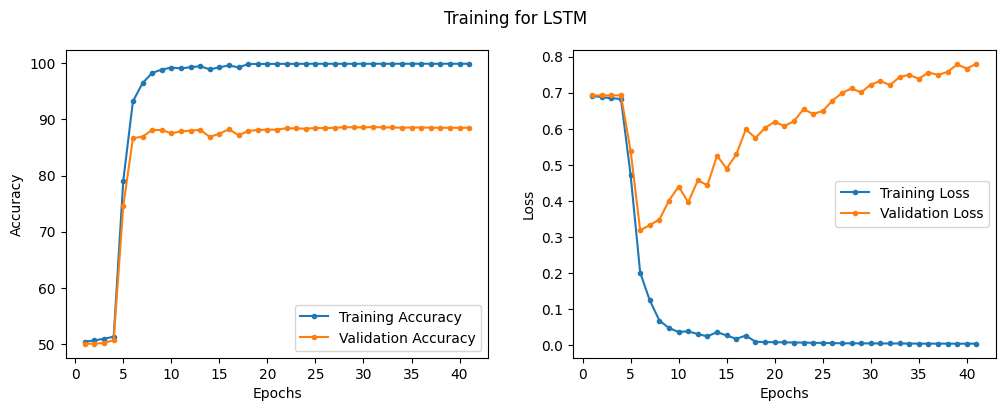

In [26]:
test_loss, test_acc = post_training(trained_model, loss_fn, test_loader, history_model, 'LSTM')